# Imports

In [1]:
import os
from time import time
from datetime import timedelta

from sklearn.model_selection import train_test_split as split
from torch import device as Device
from torch import save
from torch.backends.mps import is_available as mps_available
from torch.cuda import is_available as cuda_available
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from segmentation_models_pytorch import Unet

from src.utils.dataset import ForestDataset
from src.utils.loss import loss
from src.utils.models import evaluation, training, save, load
from src.utils.plots import plot_image_and_prediction
from src.utils.predictions import predict_image
from src.utils.preprocessing import Preprocessor

/Users/ematala/dev/tree-heights-germany/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global parameters

In [2]:
img_dir = "data/images"
patch_dir = "data/patches/64"
log_dir = "logs"
model_dir = "models"
gedi_file = "data/gedi/gedi_complete.fth"
patches_file = "data/patches/64/info.fth"
seed = 42
batch_size = 16
patch_size = 64
num_workers = 6
learning_rate = 1e-4
epochs = 2
device = Device("cuda" if cuda_available() else "mps" if mps_available() else "cpu")

print(f"Using {device} device")

Using mps device


# Preprocess labels and patches

In [3]:
# Create preprocessor
preprocessor = Preprocessor(patches_file, img_dir, patch_dir, gedi_file, patch_size)

preprocessor.run()

# Extract patches
patches = preprocessor.patches.sample(frac=0.5, random_state=seed)

print(f"Total number of patches: {len(patches)}")

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 48
INFO:root:Loaded existing patch info file. Skipping image processing.


Total number of patches: 50712


## Create datasets & dataloader

In [4]:
# Split patches
train, rest = split(patches, test_size=0.3, random_state=seed)
val, test = split(rest, test_size=0.5, random_state=seed)

# Create datasets
train_data = ForestDataset(train, patch_dir)
val_data = ForestDataset(val, patch_dir)
test_data = ForestDataset(test, patch_dir)

# Create dataloaders
train_loader = DataLoader(train_data, batch_size, True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size, False, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size, False, num_workers=num_workers)

# U-Net

## Create model

In [5]:
# Create model
model = Unet(
    encoder_weights=None,
    in_channels=4,
).to(device)

print(model)

# Create optimizer
optimizer = Adam(model.parameters(), learning_rate)

# Create writer
writer = SummaryWriter(log_dir)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Train model

In [6]:
# Training loop
start = time()

for epoch in range(epochs):
    training(train_loader, model, loss, device, writer, epoch, optimizer)
    evaluation(val_loader, model, loss, device, writer, epoch)

end = time()

writer.close()

print(f"Training completed in {timedelta(seconds=(end - start))}")

score = evaluation(test_loader, model, loss, device)

print(f"Final loss on test set: {score}")

Training Epoch 1:   0%|          | 0/2219 [00:00<?, ?it/s]/Users/ematala/dev/tree-heights-germany/.venv/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Validation Epoch 2: 100%|██████████| 476/476 [00:44<00:00, 10.67it/s]


Training completed in 0:11:11.130511


Evaluation: 100%|██████████| 476/476 [00:45<00:00, 10.50it/s]

Final loss on test set: 6.498942600328381


## Export model

In [7]:
save(model, os.path.join(model_dir, f"{model.name}.pt"))

## Load pre-trained model

In [8]:
model = load(model, os.path.join(model_dir, f"{model.name}.pt"))

## Visualise results

In [10]:
image, prediction = predict_image(
    model, device, "data/images/L15-1059E-1348N.tif", patch_size
)

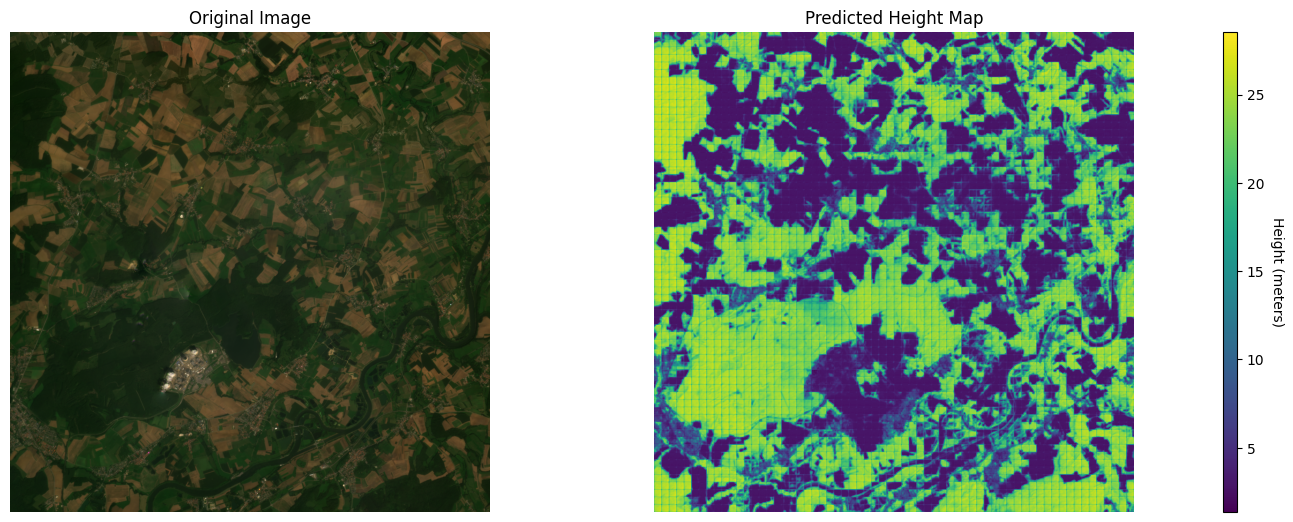

In [11]:
plot_image_and_prediction(image, prediction, 3)